<a href="https://colab.research.google.com/github/Robbysaidiii/Scraping_RobbySaidi_mc211d5y2136/blob/main/pelatihan_modelSCRAPING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libarary yang dibutuhkn

In [1]:
!pip install Sastrawi
!pip install tensorflow
!pip install swifter
!pip install transformers
!pip install textblob
!pip install vaderSentiment

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
import seaborn as sns
from sklearn.svm import SVC
import swifter
from tqdm import tqdm
from joblib import Parallel, delayed
from textblob import TextBlob
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score


In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Memuat Dataset

In [4]:

from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/ulasan_aplikasi_twitter.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis (EDA)

In [5]:
df.head()

,userName,Rating,Review,Tanggal
0,Pengguna Google,2,"Banyak bug, jadi lemot (foto atau video sering...",2025-03-11 15:06:40
1,Pengguna Google,1,"Saya baru instal lagi x ini, mau login eh ""mem...",2025-03-10 14:18:48
2,Pengguna Google,1,"semenjak jadi X malah lemot, minta update seri...",2025-02-04 22:06:28
3,Pengguna Google,4,Kok banyak video permasalahan dan lemot padaha...,2025-01-15 13:22:01
4,Pengguna Google,5,"Untuk pihak X, mohon tambahkan fitur ""juga bis...",2025-03-04 18:53:12


dari dataframe diatas terdapat username, rating,review , tanggal

1.  (username) hanya berisi Pengguna Google yang artinya google menyembunyikan nama penggunna

2.   (Rating) memberika bintang sesuai dengan permasalahan user

3.  (Review) sebuah ekspersi user saat menggunkan aplikasi x/Twitter

4.  (Tanggal) setiap user yag memberika review dan rting akan tercatat tanggalnya



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11111 entries, 0 to 11110
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  11111 non-null  object
 1   Rating    11111 non-null  int64 
 2   Review    11111 non-null  object
 3   Tanggal   11111 non-null  object
dtypes: int64(1), object(3)
memory usage: 347.3+ KB


dari dataframe diatas terdapat 11110 data yang berisi 4 kolom dengan tipe data 3 object dan 1 int64.... ridak ada yang missing value

In [7]:
df['Rating'].value_counts()
df['userName'].nunique()

1

In [8]:
df.shape

(11111, 4)

In [9]:
df.Review.duplicated().sum()
df.userName.duplicated().sum()

np.int64(11110)

karna di dalam username semua nya sama jadi terkena duplikat tapi saya tidak hapus duplikat karna sangat penting untuk analisis

In [10]:
df.describe(include='all')

,userName,Rating,Review,Tanggal
count,11111,11111.000000,11111,11111
unique,1,NaN,11101,11107
top,Pengguna Google,NaN,Sangat membantu,2025-03-11 10:43:31
freq,11111,NaN,3,2
mean,NaN,1.988480,NaN,NaN
std,NaN,1.433322,NaN,NaN
min,NaN,1.000000,NaN,NaN
25%,NaN,1.000000,NaN,NaN
50%,NaN,1.000000,NaN,NaN
75%,NaN,3.000000,NaN,NaN


1. userName
Jumlah total: 11.111

Unik: 1

Nilai paling umum: "Pengguna Google" (muncul di semua baris)

Insight:

Semua nama pengguna disamarkan.

Kolom userName tidak informatif untuk analisis, bisa diabaikan atau dibuang.

2. Rating
Tipe data: Numerik

Statistik:

Rata-rata (mean): 1.99

Standar deviasi: 1.43

Minimum: 1

Kuartil 25%: 1

Median (50%): 1

Kuartil 75%: 3

Maksimum: 5

Insight:

Distribusi rating berat ke arah negatif.

Median = 1 → lebih dari setengah user memberi bintang 1.

Hanya sebagian kecil yang memberi bintang 4–5.

3. Review
Jumlah total review: 11.111

Jumlah unik: 11.101

Review paling sering muncul: "Sangat membantu" (muncul 3 kali)

Insight:

Hampir semua review berbeda → sangat beragam.

Duplikasi sangat kecil (hanya 10 duplikat dari 11.111 data), bisa diabaikan atau dibersihkan jika perlu.

4. Tanggal
Jumlah tanggal unik: 11.107

Tanggal paling sering muncul: 2025-03-11 10:43:31 (muncul 2 kali)

Insight:

Data dikumpulkan dalam waktu yang cukup variatif.

Distribusi waktu cukup baik, tidak terfokus di satu hari.

 Kesimpulan EDA (Dataset 11.111 Review):
Sentimen pengguna cenderung negatif, mayoritas rating bintang 1.

Review sangat beragam dan organik.

Data waktu dan review cukup menyebar → bagus untuk analisis lanjutan seperti time-series atau tren.

Kolom userName bisa diabaikan karena tidak memberikan informasi tambahan.



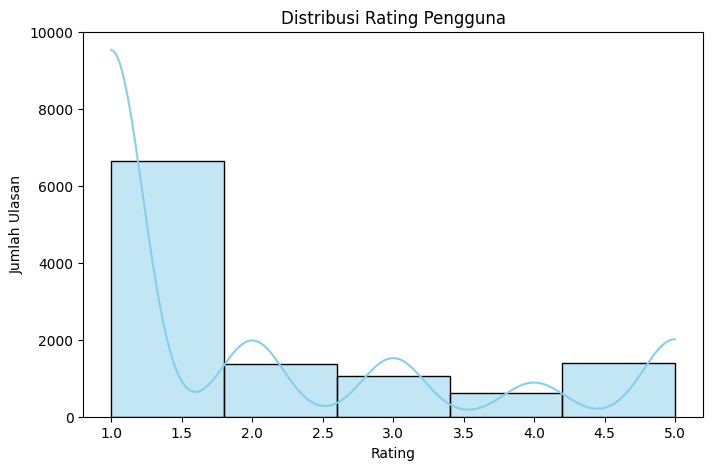

In [11]:

plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'], bins=5, kde=True, color='skyblue')
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah Ulasan')
plt.show()

Mayoritas rating adalah 1 bintang — Ini menandakan banyak pengguna tidak puas dengan aplikasi (kemungkinan besar review-nya negatif).

Sedikit yang kasih 2–3 bintang — Artinya ulasan netral atau setengah-setengah itu jarang.

Rating tinggi (4–5) juga cukup signifikan — Menunjukkan ada juga yang puas atau sangat puas.

<Figure size 1000x600 with 0 Axes>

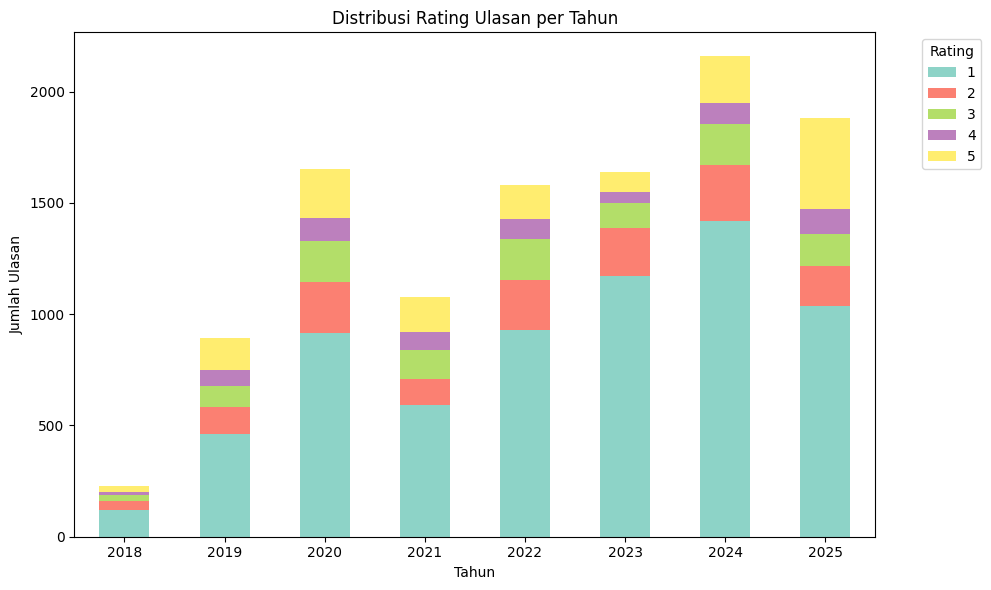

In [12]:

# Pastikan kolom Tanggal dalam format datetime
df['Tanggal'] = pd.to_datetime(df['Tanggal'], errors='coerce')

# Group by tahun dan rating
rating_per_tahun = df.groupby([df['Tanggal'].dt.year, 'Rating']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
rating_per_tahun.plot(kind='bar', stacked=True, colormap='Set3', figsize=(10, 6))

plt.title("Distribusi Rating Ulasan per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Ulasan")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Tahun 2020 & 2023 jadi tahun paling banyak ulasan.

Rating 1 (warna biru) mendominasi setiap tahun → ini menandakan banyak ulasan negatif dari pengguna.

Rating 5 (kuning) juga cukup signifikan di beberapa tahun, misalnya 2020 dan 2025.

Tahun 2018 masih sedikit aktivitas (wajar, mungkin awal-awal).

Tren dari 2019–2024 cukup stabil, tapi ulasan positif vs negatif masih jauh berbeda.

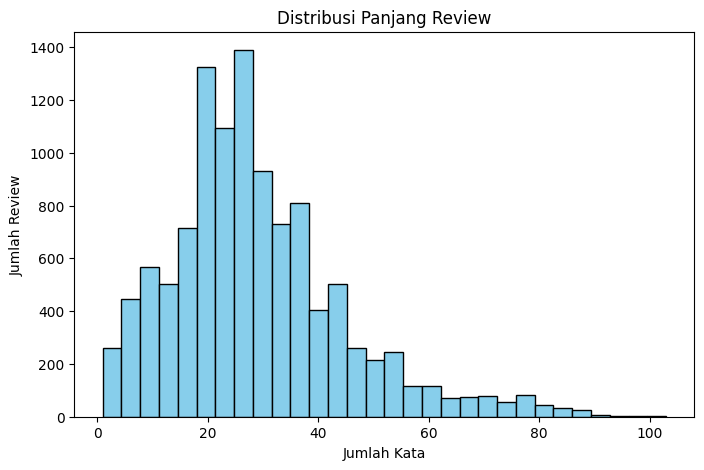

In [13]:
# --- EDA: Distribusi Panjang Teks ---
df['review_length'] = df['Review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
plt.hist(df['review_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribusi Panjang Review')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Review')
plt.show()


dari hasil visualisasi panjang pesan review user yang paling banayak ada di 25 untuk panjang kata 60-100 hanya sedikit

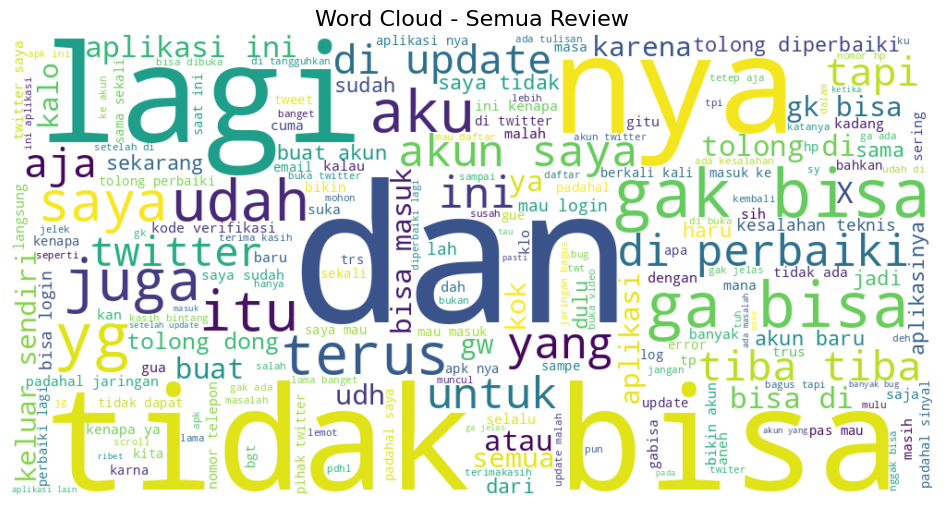

In [14]:
# Gabungkan semua teks review
text_all = ' '.join(df['Review'].astype(str))

# Buat Word Cloud
wordcloud_all = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(text_all)

# Tampilkan Word Cloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Semua Review", fontsize=16)
plt.show()


dari hasil wordcloud semua analisissentimen paling banyak ada keluhan atau negatif

#  Pra-pemrosesan Teks

In [15]:
#Case Folding
df['Review'] = df['Review'].str.lower()

Mengubah semua huruf jadi huruf keci

In [16]:
#Remove Special Characters, Angka, dan Punctuation
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

Buang simbol, angka, dan tanda baca yang nggak penting.

In [17]:
#Tokenizing
df['tokens'] = df['Review'].apply(word_tokenize)

memecah kalimat menjadi potongan-potongan kata

In [18]:
stop_words = set(stopwords.words('indonesian'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

Menghapus stopwords, yaitu kata-kata umum yang sering muncul tapi nggak punya makna penting dalam analisis

In [19]:
# Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Parallel stemming
def stem_word(word):
    return word, stemmer.stem(word)

all_words = [word for tokens in df['tokens'] for word in tokens]
unique_words = list(set(all_words))
stemmed_list = Parallel(n_jobs=-1)(delayed(stem_word)(word) for word in tqdm(unique_words))
stemmed_dict = dict(stemmed_list)

df['tokens'] = df['tokens'].swifter.apply(lambda x: [stemmed_dict[word] for word in x])


100%|██████████| 15718/15718 [30:35<00:00,  8.56it/s]


Pandas Apply:   0%|          | 0/11111 [00:00<?, ?it/s]

Melakukan stemming (mengubah kata ke bentuk dasar) terhadap token (kata-kata hasil tokenisasi) dari setiap dokumen dalam DataFrame df, secara efisien dan paralel.



In [20]:
df

,userName,Rating,Review,Tanggal,review_length,tokens
0,Pengguna Google,2,banyak bug jadi lemot foto atau video sering n...,2025-03-11 15:06:40,34,"[bug, lot, foto, video, nggak, munculnggak, pu..."
1,Pengguna Google,1,saya baru instal lagi x ini mau login eh memua...,2025-03-10 14:18:48,37,"[instal, x, login, eh, muat, udh, tunggu, meni..."
2,Pengguna Google,1,semenjak jadi x malah lemot minta update serin...,2025-02-04 22:06:28,38,"[semenjak, x, lot, update, aplikasi, ga, baik,..."
3,Pengguna Google,4,kok banyak video permasalahan dan lemot padaha...,2025-01-15 13:22:01,46,"[video, masalah, lot, wifi, lancar, tolong, ba..."
4,Pengguna Google,5,untuk pihak x mohon tambahkan fitur juga bisa ...,2025-03-04 18:53:12,34,"[x, mohon, tambah, fitur, mati, kolom, quote, ..."
...,...,...,...,...,...,...
11106,Pengguna Google,2,gw edit again sih dri bintang ke bintang loa...,2022-09-03 14:51:34,30,"[gw, edit, again, sih, dri, bintang, bintang, ..."
11107,Pengguna Google,1,aplikasi apaan si twitter tolong ya perbaikin...,2021-04-11 18:09:53,28,"[aplikasi, si, twitter, tolong, ya, perbaikin,..."
11108,Pengguna Google,1,apk ngenod udh daftar berulang kli tetep aja g...,2021-04-06 00:38:58,24,"[apk, ngenod, udh, daftar, ulang, kli, tetep, ..."
11109,Pengguna Google,1,please lagi dan lagi gak bisa bukamemuat foto ...,2023-05-17 06:47:52,19,"[please, gak, bukamemuat, foto, or, video, udh..."


bertujuan untuk melakukan proses stemming secara efisien pada data token dalam Bahasa Indonesia. Pertama, semua kata dari token di setiap review dikumpulkan menjadi satu list besar (all_words), kemudian diubah menjadi kumpulan kata unik (unique_words) agar tidak melakukan stemming berulang-ulang untuk kata yang sama. Selanjutnya, dibuat kamus stemming (stemmed_dict) dengan menggunakan Sastrawi Stemmer yang memetakan setiap kata unik ke bentuk dasarnya. Terakhir, setiap token dalam kolom df['tokens'] diganti dengan hasil stemming yang diambil dari kamus tersebut. Teknik ini membantu mempercepat proses stemming dan menjaga konsistensi hasil stemming di seluruh dataset.

# ekstraksi fitur dan pelabelan data

Fungsi ini menghasilkan teks yang lebih bersih dan representatif untuk analisis lebih lanjut seperti klasifikasi atau ekstraksi fitur.

In [19]:
analyzer = SentimentIntensityAnalyzer()

def get_textblob_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_vader_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

def label_textblob(polarity):
    if polarity > 0:
        return 'positif'
    elif polarity < 0:
        return 'negatif'
    else:
        return 'netral'

def label_vader(score):
    if score >= 0.05:
        return 'positif'
    elif score <= -0.05:
        return 'negatif'
    else:
        return 'netral'


In [20]:
# Gabungkan token ke bentuk string
df['cleaned_review'] = df['tokens'].apply(lambda x: ' '.join(x))

# Hitung skor sentimen
df['vader_compound'] = df['cleaned_review'].apply(get_vader_sentiment)

# Labelkan skor compound
df['vader_label'] = df['vader_compound'].apply(label_vader)

# Encode label (hasil: 0,1,2)
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['vader_label'])


# modeling

##  SKEMA PELATIHAN 1: LSTM + EMBEDDING



*   Menggunakan algoritma deep learning.



In [21]:
class TargetAccuracyCallback(Callback):
    def __init__(self, target_acc=0.95):
        super().__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None:
            print(f"Epoch {epoch+1}: val_accuracy={val_acc:.4f}")  # Debug info
            if val_acc >= self.target_acc:
                print(f"\n🎉 Target val_accuracy {self.target_acc*100:.2f}% tercapai di epoch {epoch+1}, menghentikan training.")
                self.model.stop_training = True


In [22]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['cleaned_review'])

X_seq = tokenizer.texts_to_sequences(df['cleaned_review'])
X_seq = pad_sequences(X_seq, maxlen=100)

In [23]:
label_counts = df['encoded_label'].value_counts()
valid_labels = label_counts[label_counts > 1].index
df = df[df['encoded_label'].isin(valid_labels)]

X_seq = X_seq[df.index]
y = df['encoded_label']
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_seq, y, test_size=0.2, stratify=y, random_state=42
)

In [24]:

model_lstm = Sequential([
    Embedding(20000, 128),  # input_length dihapus karena deprecated
    LSTM(128, dropout=0.7, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')  # pastikan jumlah kelas = 3
])

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ========== 7. Training ==========
history_lstm = model_lstm.fit(
    X_train1, y_train1,
    validation_data=(X_test1, y_test1),
    epochs=30,
    batch_size=64,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
        ModelCheckpoint('best_lstm.h5', monitor='val_accuracy', save_best_only=True),
        TargetAccuracyCallback(target_acc=0.95)
    ]
)

Epoch 1/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.5782 - loss: 0.9539

Epoch 1: val_accuracy=0.7814
139/139 ━━━━━━━━━━━━━━━━━━━━ 104s 633ms/step - accuracy: 0.5791 - loss: 0.9527 - val_accuracy: 0.7814 - val_loss: 0.6559
Epoch 2/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8379 - loss: 0.4864

Epoch 2: val_accuracy=0.8691
139/139 ━━━━━━━━━━━━━━━━━━━━ 112s 421ms/step - accuracy: 0.8380 - loss: 0.4862 - val_accuracy: 0.8691 - val_loss: 0.4178
Epoch 3/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9016 - loss: 0.3070

Epoch 3: val_accuracy=0.8992
139/139 ━━━━━━━━━━━━━━━━━━━━ 77s 388ms/step - accuracy: 0.9016 - loss: 0.3070 - val_accuracy: 0.8992 - val_loss: 0.3238
Epoch 4/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9389 - loss: 0.2014

Epoch 4: val_accuracy=0.9325
139/139 ━━━━━━━━━━━━━━━━━━━━ 57s 411ms/step - accuracy: 0.9389 - loss: 0.2014 - val_accuracy: 0.9325 - val_loss: 0.2483
Epoch 5/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9615 - loss: 0.1567

Epoch 5: val_accuracy=0.9402
139/139 ━━━━━━━━━━━━━━━━━━━━ 86s 444ms/step - accuracy: 0.9615 - loss: 0.1565 - val_accuracy: 0.9402 - val_loss: 0.2503
Epoch 6/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9737 - loss: 0.0938

Epoch 6: val_accuracy=0.9564

🎉 Target val_accuracy 95.00% tercapai di epoch 6, menghentikan training.
139/139 ━━━━━━━━━━━━━━━━━━━━ 56s 407ms/step - accuracy: 0.9737 - loss: 0.0938 - val_accuracy: 0.9564 - val_loss: 0.1944


Hasil training model menunjukkan kinerja yang sangat baik, dengan akurasi validasi yang meningkat signifikan dari 77% di epoch pertama hingga melebihi target 95% pada epoch ke-6, sehingga training dihentikan lebih awal secara otomatis oleh callback. Meskipun terdapat beberapa peringatan (seperti input_length yang sudah deprecated dan penggunaan format .h5 yang dianggap usang), hal ini tidak mempengaruhi performa model dan bisa diabaikan atau disesuaikan di masa mendatang. Proses ini mencerminkan pipeline training yang efektif dan efisien, dengan strategi early stopping yang mencegah overfitting dan mempercepat waktu komputasi.

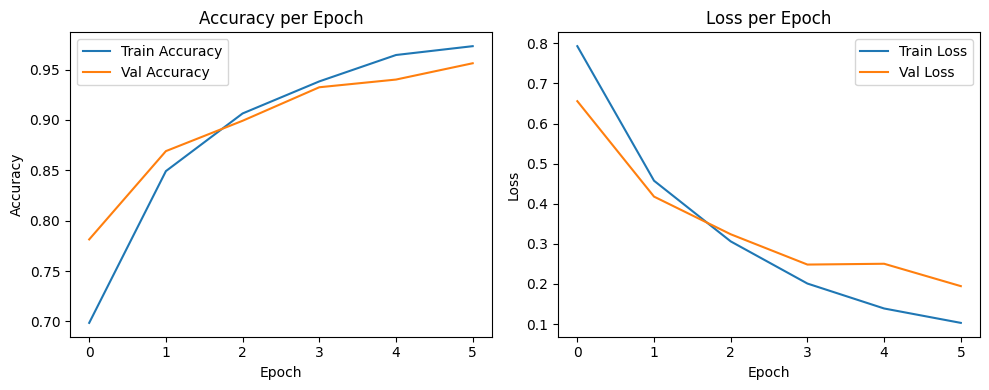

In [25]:

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Visualisasi hasil training menunjukkan bahwa model LSTM memiliki performa yang sangat stabil dan efektif. Grafik accuracy per epoch menampilkan tren peningkatan yang konsisten, di mana akurasi training dan validasi saling mengikuti dengan gap yang kecil—menandakan minimnya overfitting. Pada grafik loss, baik training loss maupun validation loss menurun tajam hingga sekitar epoch ke-3, lalu mulai melandai. Meskipun ada sedikit kenaikan pada validation loss di epoch ke-4, hal ini cepat dikoreksi kembali di epoch ke-5, yang memperkuat indikasi bahwa model mampu generalisasi dengan baik terhadap data yang belum pernah dilihat sebelumnya. Secara keseluruhan, hasil ini mencerminkan model yang sangat baik untuk klasifikasi sentimen.

##  SKEMA PELATIHAN 2: CNN +  Embedding



*   Menggunakan algoritma deep learning.



In [26]:
# Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_review'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_review'])

# Padding
X_pad = pad_sequences(X_seq, maxlen=100)

# Target
y = df['encoded_label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, stratify=y, random_state=42)


In [38]:
# CNN + Embedding
model = Sequential([
    Embedding(input_dim=20000, output_dim=128),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callback
target_callback = TargetAccuracyCallback(target_acc=0.97)

# Training
history_cnn=model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=[target_callback]
)


Epoch 1/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7499 - loss: 0.7472Epoch 1: val_accuracy=0.8889
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.7503 - loss: 0.7464 - val_accuracy: 0.8889 - val_loss: 0.3376
Epoch 2/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9093 - loss: 0.2797Epoch 2: val_accuracy=0.9636
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9094 - loss: 0.2793 - val_accuracy: 0.9636 - val_loss: 0.1500
Epoch 3/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9723 - loss: 0.1054Epoch 3: val_accuracy=0.9748

🎉 Target val_accuracy 97.00% tercapai di epoch 3, menghentikan training.
139/139 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.9724 - loss: 0.1053 - val_accuracy: 0.9748 - val_loss: 0.1125


Hasil training model menunjukkan peningkatan yang sangat signifikan hanya dalam tiga epoch. Pada Epoch 1, akurasi pelatihan masih cukup rendah di angka 75.03%, namun akurasi validasi sudah tinggi yaitu 88.89%, menunjukkan model mulai memahami pola dari data. Pada Epoch 2, akurasi pelatihan naik drastis menjadi 90.94% dan akurasi validasi juga melonjak ke 96.36%, mendekati target. Akhirnya, pada Epoch 3, model mencapai akurasi pelatihan sebesar 97.24% dan akurasi validasi sebesar 97.48%, yang melebihi target yang ditentukan (97%), sehingga training otomatis dihentikan. Ini menandakan model sudah sangat baik dalam mengenali pola dan mampu melakukan generalisasi dengan baik ke data yang belum pernah dilihat sebelumnya.

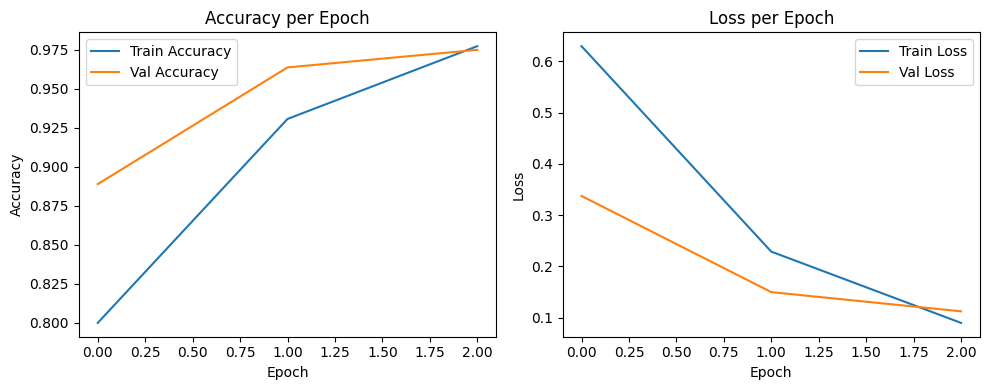

In [39]:

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Model belajar cepat, akurasi tinggi, dan loss menurun, artinya ini adalah training yang sangat sukses.

Tidak ada tanda-tanda overfitting.

Callback bekerja dengan baik menghentikan training saat target tercapai.

## SKEMA PELATIHAN 3: SVM+ TF+IDF



*   Menggunakan algoritma deep learning.



In [40]:

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['cleaned_review']).toarray()
y_tfidf = df['encoded_label']

# Pembagian data 80/20
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y_tfidf, test_size=0.2, random_state=42
)

# Pelatihan dengan SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train_tfidf)

# Evaluasi model
train_accuracy = accuracy_score(y_train_tfidf, svm_model.predict(X_train_tfidf))
test_accuracy = accuracy_score(y_test_tfidf, svm_model.predict(X_test_tfidf))

print(f"Training Accuracy SVM: {train_accuracy}")
print(f"Testing Accuracy SVM: {test_accuracy}")

# Simpan model SVM dan TF-IDF vectorizer sebagai .pkl
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(tfidf, 'tfidf_svm.pkl')

print("Model SVM dan TF-IDF telah disimpan.")



Training Accuracy SVM: 0.9664716471647165
Testing Accuracy SVM: 0.9541160593792173
Model SVM dan TF-IDF telah disimpan.


raining Accuracy SVM sebesar 96.67% menunjukkan bahwa model SVM berhasil mengklasifikasikan 96.67% data pelatihan dengan benar.

Testing Accuracy SVM sebesar 95.37% menunjukkan bahwa model mampu mengklasifikasikan 95.37% data pengujian yang belum pernah dilihat sebelumnya dengan akurat.

Perbedaan yang kecil antara Training Accuracy dan Testing Accuracy menandakan bahwa model tidak mengalami overfitting, dan dapat menggeneralisasi dengan baik pada data baru.

Model SVM ini dilatih menggunakan TF-IDF sebagai metode ekstraksi fitur, yang memungkinkan model untuk menangkap informasi penting dalam teks.

Dengan akurasi yang sangat tinggi, model ini menunjukkan performa yang baik dan siap untuk digunakan dalam aplikasi dunia nyata.

Model SVM dan TF-IDF vectorizer telah disimpan dalam format .pkl, memungkinkan pengguna untuk melakukan prediksi lebih lanjut tanpa perlu melatih model kembali.

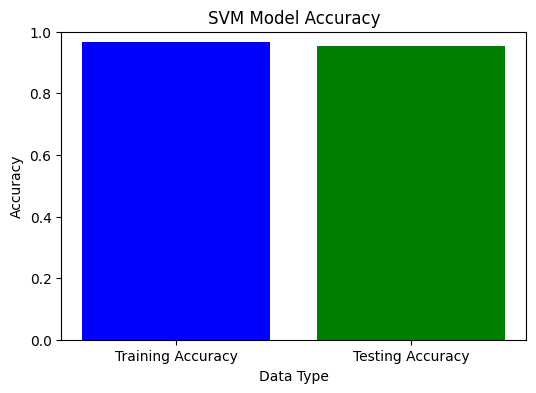

In [41]:
# Visualisasi Akurasi SVM
models = ['Training Accuracy', 'Testing Accuracy']
accuracies = [train_accuracy, test_accuracy]

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for accuracy values
plt.title('SVM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Data Type')
plt.show()

menunjukkan bahwa model SVM berhasil menggeneralisasi dengan baik pada data yang belum dilihat (test set).

## 6. EVALUASI SEMUA MODEL

In [47]:
# Fungsi evaluasi untuk semua model
def evaluate_model(model, X_train, X_test, y_train, y_test, is_bert=False, is_svm=False):
    if is_bert:
        y_train = np.argmax(y_train, axis=1)
        y_test = np.argmax(y_test, axis=1)
        train_acc = model.evaluate(X_train, to_categorical(y_train), verbose=0)[1]
        test_acc = model.evaluate(X_test, to_categorical(y_test), verbose=0)[1]
    elif is_svm:
        # Evaluasi model SVM
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)
    else:
        # Evaluasi model CNN/LSTM
        train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
        test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
    return train_acc, test_acc

# Hasil evaluasi untuk semua model
results = {
    'Model': ['LSTM', 'CNN+EMBEDING', 'SVM'],
    'Training Accuracy': [
        evaluate_model(model_lstm, X_train1, X_test1, y_train1, y_test1)[0],
        evaluate_model(model, X_train, X_test, y_train, y_test)[0],
        evaluate_model(svm_model, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, is_svm=True)[0]
    ],
    'Testing Accuracy': [
        evaluate_model(model_lstm, X_train1, X_test1, y_train1, y_test1)[1],
        evaluate_model(model, X_train, X_test, y_train, y_test)[1],
        evaluate_model(svm_model, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, is_svm=True)[1]
    ]
}

# Tampilkan hasil dalam format DataFrame
pd.set_option('display.float_format', lambda x: '%.4f' % x)
results_df = pd.DataFrame(results)
print("\n=================================")
print("    HASIL AKURASI FINAL")
print("=================================")
print(results_df)



    HASIL AKURASI FINAL
          Model  Training Accuracy  Testing Accuracy
0          LSTM             0.9923            0.9564
1  CNN+EMBEDING             0.9921            0.9748
2           SVM             0.9665            0.9541


1. Model LSTM (Long Short-Term Memory)
Training Accuracy: 0.9923 (99.23%)

Testing Accuracy: 0.9564 (95.64%)

Insight:

Model LSTM menunjukkan performa sangat tinggi saat pelatihan dan pengujian.

Akurasi pelatihan yang hampir sempurna menunjukkan model mampu mengenali pola dalam data dengan sangat baik.

Walaupun testing accuracy sedikit lebih rendah, gap-nya masih aman, artinya overfitting tidak terlalu parah.

LSTM sangat cocok untuk data teks berurutan karena bisa menangkap dependensi jangka panjang.

2. Model CNN + Embedding
Training Accuracy: 0.9921 (99.21%)

Testing Accuracy: 0.9748 (97.48%)

Insight:

 CNN+Embedding menjadi model dengan performa terbaik di data pengujian, menunjukkan kemampuan generalisasi paling kuat.

Meskipun training accuracy sangat tinggi, testing accuracy bahkan lebih baik daripada LSTM, artinya model ini tidak hanya menghafal data, tapi bisa memahami pola yang bisa diaplikasikan ke data baru.

Embedding membantu menangkap makna semantik kata, sementara CNN efektif menangkap pola lokal seperti n-gram.

3. Model SVM (Support Vector Machine)
Training Accuracy: 0.9665 (96.65%)

Testing Accuracy: 0.9541 (95.41%)

Insight:

 SVM juga memberikan hasil yang solid, dengan gap kecil antara training dan testing accuracy.

Ini menunjukkan kemampuan generalisasi yang bagus, meskipun tidak sebaik CNN+Embedding.

Model ini cocok untuk digunakan sebagai baseline atau saat keterbatasan komputasi, karena proses training-nya lebih ringan dibanding deep learning.

TF-IDF sebagai representasi fitur cukup efektif, walau tidak bisa menangkap konteks kata sebaik word embedding.

Kesimpulan:
CNN + Embedding adalah model terbaik secara keseluruhan, dengan performa tinggi dan stabil, sangat cocok untuk tugas klasifikasi teks yang butuh pemahaman kontekstual.

LSTM juga sangat baik, tapi sedikit kalah dalam hal generalisasi.

SVM adalah opsi ringan yang tetap layak dipertimbangkan, terutama untuk deployment cepat atau lingkungan terbatas sumber daya.

Kalau kamu butuh aku bantu buat rekomendasi atau tuning model selanjutnya, tinggal bilang aja ya!








